In [1]:
import torch
from torch import nn
import numpy as np
from model_parameters import ModelParameters
from tqdm import tqdm
import time
from helper.torch_training import run_torch_sequence
from helper.scores import Metrics

# Data Loading

In [2]:
model_parameters = ModelParameters()
x_train, x_test, y_train, y_test = model_parameters.get_htru_2()

# Model definition

In [3]:
class ClassicCNN(torch.nn.Module):
    def __init__(self, num_features):
        super(ClassicCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(16 * 3, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        x = x.squeeze(1)
        return x
        

def model_creator():
    return ClassicCNN(model_parameters.num_features)

## Training CNN

### Normal QCNN

CNN trained on each data without batches and no early stopping.

100%|██████████| 6/6 [02:46<00:00, 27.76s/it]


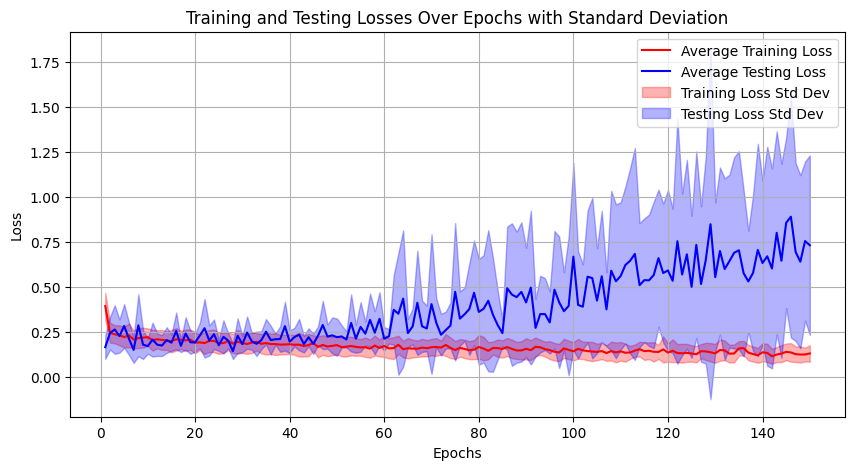

Pour 6 runs:
Accuracy: 0.943 ± 0.017
Balanced Accuracy: 0.928 ± 0.023
Recall: 0.909 ± 0.050
Specificity: 0.947 ± 0.020
Precision: 0.655 ± 0.101
NPV: 0.990 ± 0.006
G-Mean: 0.928 ± 0.023
Informedness: 0.856 ± 0.047
Training Duration: 27.626 ± 0.252
Testing Duration: 0.001 ± 0.001


In [4]:
metrics = Metrics()
run_torch_sequence(model_parameters, model_creator, x_train, y_train, x_test, y_test, metrics, batch_size=1)
metrics.display()

### Normal QCNN with early stopping

CNN trained on each data without batches and early stopping.

 17%|█▋        | 1/6 [00:01<00:05,  1.11s/it]

Stopping early at epoch 6. Validation loss has not improved for 5 epochs.


 33%|███▎      | 2/6 [00:02<00:04,  1.21s/it]

Stopping early at epoch 7. Validation loss has not improved for 5 epochs.


 50%|█████     | 3/6 [00:04<00:04,  1.50s/it]

Stopping early at epoch 10. Validation loss has not improved for 5 epochs.


 67%|██████▋   | 4/6 [00:06<00:03,  1.83s/it]

Stopping early at epoch 13. Validation loss has not improved for 5 epochs.


 83%|████████▎ | 5/6 [00:09<00:02,  2.36s/it]

Stopping early at epoch 18. Validation loss has not improved for 5 epochs.


100%|██████████| 6/6 [00:10<00:00,  1.83s/it]

Stopping early at epoch 6. Validation loss has not improved for 5 epochs.


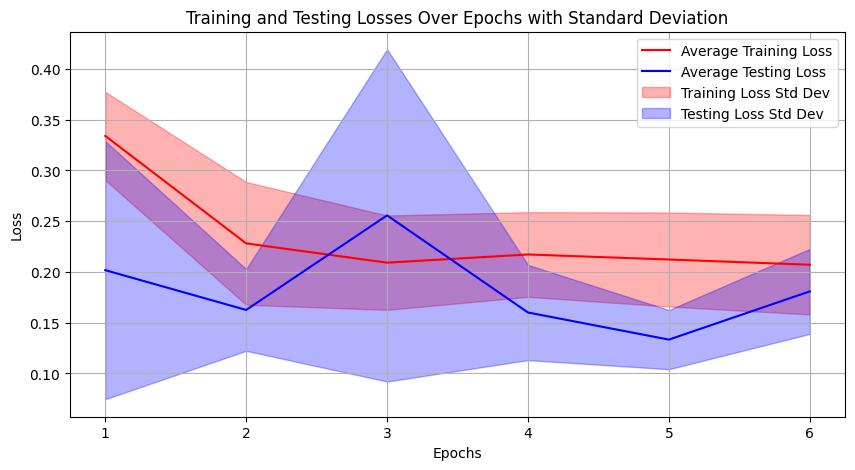

Pour 6 runs:
Accuracy: 0.913 ± 0.036
Balanced Accuracy: 0.898 ± 0.038
Recall: 0.879 ± 0.094
Specificity: 0.917 ± 0.045
Precision: 0.569 ± 0.173
NPV: 0.987 ± 0.009
G-Mean: 0.895 ± 0.041
Informedness: 0.796 ± 0.076
Training Duration: 1.813 ± 0.799
Testing Duration: 0.001 ± 0.001


In [8]:
metrics = Metrics()
run_torch_sequence(model_parameters, model_creator, x_train, y_train, x_test, y_test, metrics, batch_size=1, early_stopping_threshold=0)
metrics.display()

### Batch QCNN with early stopping

CNN trained on each data with batches and early stopping.

 33%|███▎      | 2/6 [00:00<00:00,  5.85it/s]

Stopping early at epoch 37. Validation loss has not improved for 5 epochs.
Stopping early at epoch 28. Validation loss has not improved for 5 epochs.
Stopping early at epoch 18. Validation loss has not improved for 5 epochs.


 83%|████████▎ | 5/6 [00:00<00:00,  6.01it/s]

Stopping early at epoch 35. Validation loss has not improved for 5 epochs.
Stopping early at epoch 31. Validation loss has not improved for 5 epochs.


100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


Stopping early at epoch 24. Validation loss has not improved for 5 epochs.


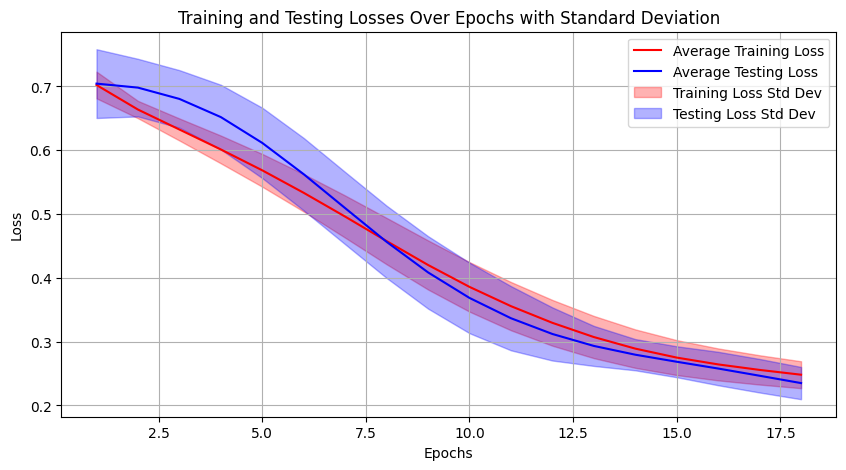

Pour 6 runs:
Accuracy: 0.945 ± 0.013
Balanced Accuracy: 0.920 ± 0.014
Recall: 0.889 ± 0.033
Specificity: 0.950 ± 0.016
Precision: 0.672 ± 0.066
NPV: 0.987 ± 0.003
G-Mean: 0.919 ± 0.014
Informedness: 0.839 ± 0.028
Training Duration: 0.150 ± 0.070
Testing Duration: 0.001 ± 0.000


In [9]:
metrics = Metrics()
run_torch_sequence(model_parameters, model_creator, x_train, y_train, x_test, y_test, metrics, batch_size=200, early_stopping_threshold=0.0005)
metrics.display()